In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from src.variablesName import VariablesName
import src.pathconfig as pathcfg

vNames = VariablesName()

In [2]:
import pandas as pd
import numpy as np

# set seed for reproducibility
np.random.seed(0) 

In [3]:
folderpath = pathcfg.folderpath
filepath = f"{folderpath}/2017-2018_NSCH_DRC.csv.gzip"

In [4]:
df = pd.read_csv(filepath, index_col='HHID', compression='gzip')
have_autism = df[['K2Q35B']].fillna(2)
df = df[[col for col in df.columns.values if col != 'K2Q35B']]

In [5]:
from scipy.stats import spearmanr
cor_col = []
p_value_col = []
for col in df.columns.values:
    cor, p_value = spearmanr(df[col].values, have_autism.values, nan_policy='omit')
    cor_col.append(cor)
    p_value_col.append(cor)
#     print(f"{col} - spearman: {cor} - p-value: {p_value}")

df_spearman_corr = pd.DataFrame({'spearman': cor_col,
                                 'p_value': p_value_col},
                                 index=df.columns.values)
# df_spearman_corr = df_spearman_corr.sort_values(by=['spearman'], ascending=False)

df_spearman_corr.reset_index(inplace=True)
df_spearman_corr['description'] = df_spearman_corr['index'].apply(lambda x: vNames.descriptionOfColumn(x))
df_spearman_corr.set_index('index', inplace=True)

In [6]:
description_itens_list = ['screener', 'asd', 'autism', 'sc ', 'cshcn', 'indicator'] 
autism_related_columns = [col for col in vNames.allColumns() if any(c in vNames.descriptionOfColumn(col).lower() for c in description_itens_list)]
# print(autism_related_columns)

In [7]:
# for col in autism_related_columns:
#     print(f"{col}   {vNames.descriptionOfColumn(col)}")

In [8]:
df = df[[col for col in df.columns if col not in autism_related_columns]]

In [9]:
filter_func = lambda x, lim: x>lim or x<-lim

selected_columns = (df_spearman_corr[df_spearman_corr.spearman.apply(lambda x: filter_func(x, 0.1))].index.values.tolist())

model_columns = [col for col in selected_columns if col in df.columns]
df_to_model = df[model_columns]
# df_to_model.head()

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from seaborn import palplot, color_palette

color_pal = color_palette("Set1")
excludedColor = color_pal[-1]
notExcludedModelColor = color_pal[0]

df_spearman_corr.reset_index(inplace=True)
df_spearman_corr['color'] = df_spearman_corr['index'].apply(lambda x: notExcludedModelColor if x in model_columns else excludedColor)
df_spearman_corr.set_index('index', inplace=True)


notExcluded_patch = mpatches.Patch(color=notExcludedModelColor, label='Not Excluded Question')
excluded_patch = mpatches.Patch(color=excludedColor, label='Excluded Question')

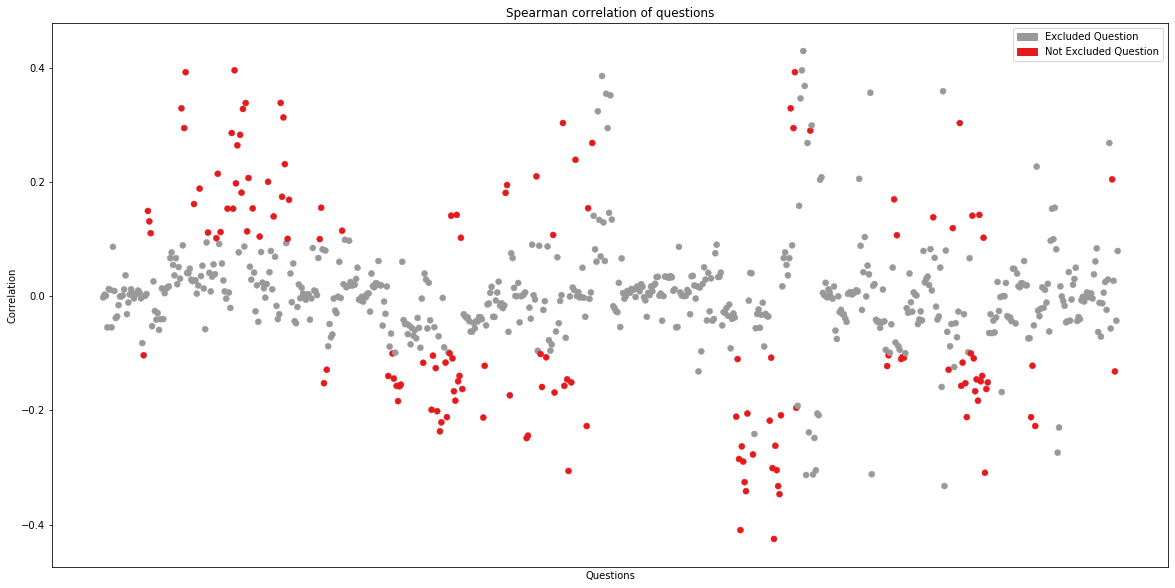

In [11]:
%matplotlib inline

cfg = {'linewidth':0.5,
      'marker':'o'}

# marker=markerList,
plt.figure(figsize=(20, 10))
fig = plt.scatter(df_spearman_corr.index, df_spearman_corr.spearman, c=df_spearman_corr.color, **cfg)

plt.title("Spearman correlation of questions")
plt.ylabel('Correlation')
plt.xlabel('Questions')
plt.xticks(list())
plt.legend(handles=[excluded_patch, notExcluded_patch])

plt.show()

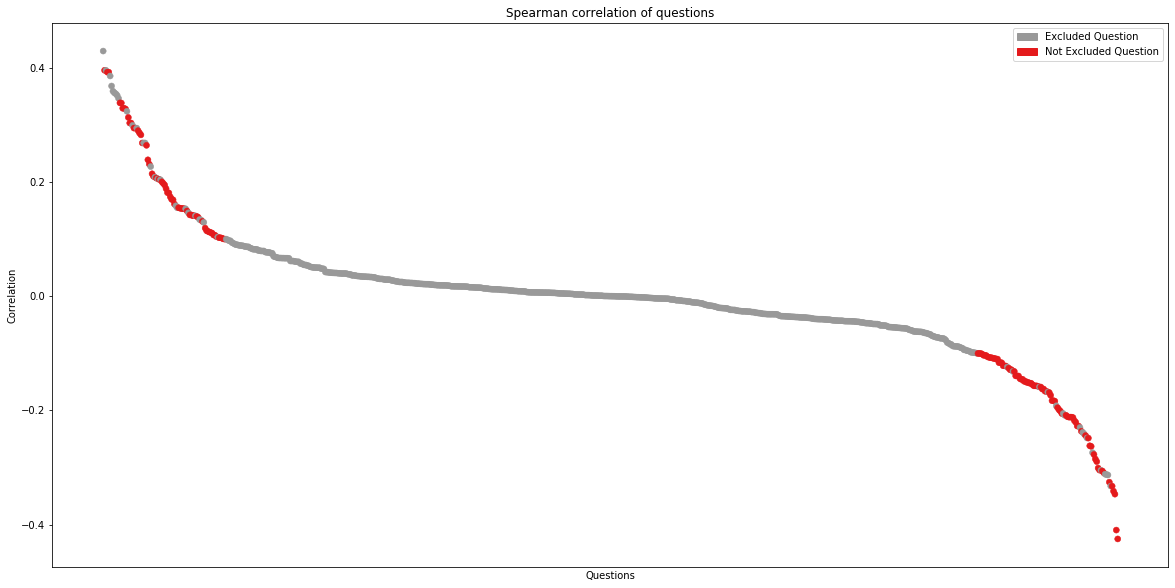

In [12]:
%matplotlib inline 


cfg = {'linewidth':0.5,
      'marker':'o'}
df_plot = df_spearman_corr
df_plot = df_spearman_corr.sort_values(by=['spearman'], ascending=False)

# marker=markerList,
plt.figure(figsize=(20, 10))
fig = plt.scatter(df_plot.index, df_plot.spearman, c=df_plot.color, **cfg)

plt.title("Spearman correlation of questions")
plt.ylabel('Correlation')
plt.xlabel('Questions')
plt.xticks(list())
plt.legend(handles=[excluded_patch, notExcluded_patch])

plt.show()